# 음악 취향 추천 시스템

In [1]:
import pandas as pd
import os
import re

import numpy as np
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from konlpy.tag import Okt

import seaborn as sns
import matplotlib.pyplot as plt


np.random.seed(40)

In [2]:
import seaborn as sns

import numpy as np

import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head()

,user_id,artist_MBID,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


# 데이터 전처리

### 분석에 사용할 column만 선택

In [3]:
use_col = ['user_id', 'artist', 'play']
data = data[use_col]
data.head()

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


### NaN값 제거

In [5]:
from IPython.core import display as ICD
ICD.display(data[data.isnull().any(axis=1)].head(3))
data = data.dropna(how='any')

,user_id,artist,play
244853,039e5d61d65bbf5e6d95b07b1b3b67f7fd287a62,NaN,18
431015,065a001be5a8a55971042077933e263d0d5cde46,NaN,186
455721,06b17c50402d06a497cb13a0375992fd1e90b392,NaN,3


### 아티스트 이름 소문자 변환

In [6]:
data['artist'] = data['artist'].str.lower()
data.head()

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


### 전체에서 n번만 등장한 가수 제거

<AxesSubplot:>

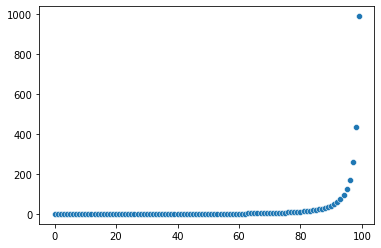

In [170]:
#plt.figure(figsize=(15,5))
#plt.subplot(1,3,1)
sns.scatterplot(data=min_count_list, x_bins=10)

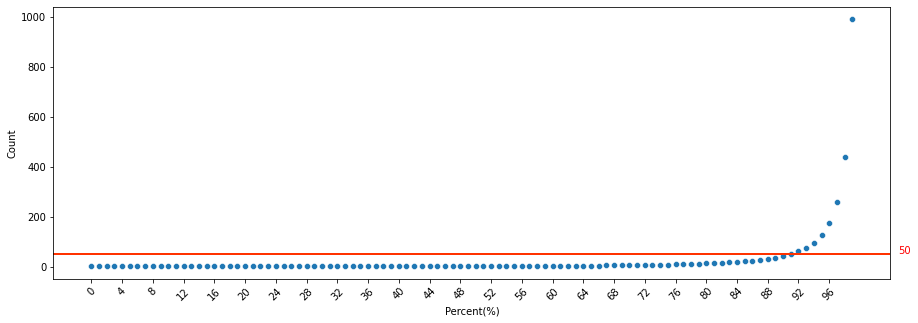

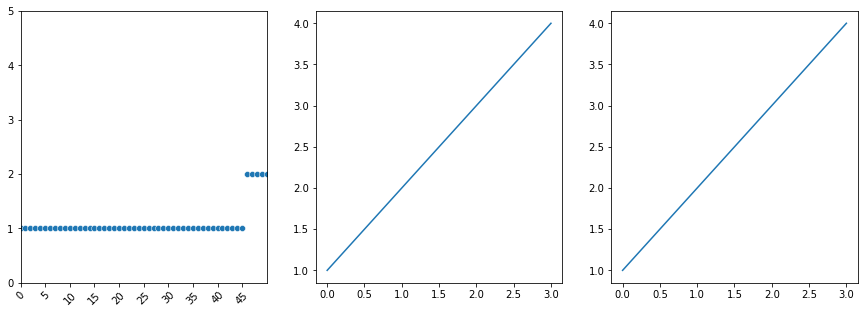

In [175]:
min_count_list = []
for i in range(100):
    min_count = np.percentile(count_list, i)
    min_count_list.append(min_count)
    
plt.figure(figsize=(15,5))
sns.scatterplot(data=min_count_list, x_bins=30)
plt.axhline(y=50, color='#ff3300', linewidth=2, label='Threshold Value')  # 빨간 표시줄 그리기
plt.text(105, 50, '50', color='red')                                 # 빨간 표시줄 xtick(위)
plt.xlabel('Percent(%)')
plt.ylabel('Count')
plt.xticks([i*4 for i in range(25)], rotation=45)
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(data=min_count_list, x_bins=30)
plt.xticks([i*5 for i in range(10)], rotation=45)
plt.xlim([0,50])
plt.ylim([0,5])
plt.subplot(1,3,2)
plt.plot([1,2,3,4])
plt.subplot(1,3,3)
plt.plot([1,2,3,4])
plt.show()

50% of data :  2.0


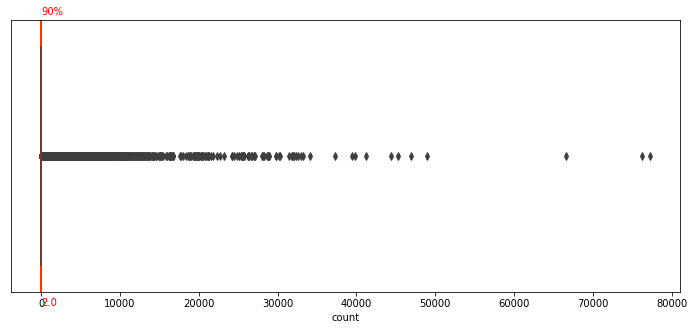

In [102]:
percent = 50
min_count = np.percentile(count_list, percent)        # 특정 Percent에 해당하는 데이터 길이 출력(90퍼로 결정)
print(f'{percent}% of data : ', min_count)

plt.figure(figsize=(12, 5))
sns.boxplot(data=count_list, orient='h')
plt.axvline(x=min_count, color='#ff3300', linewidth=2, label='Threshold Value')  # 빨간 표시줄 그리기
plt.text(min_count-2, -0.52, '90%', color='red')                                 # 빨간 표시줄 xtick(위)
plt.text(min_count-2,0.55, min_count, color='red')                                 # 빨간 표시줄 xtick(아래)
plt.xlabel('count')
plt.yticks([])
plt.show()


In [67]:
artist_count = data.groupby('artist')['user_id'].count()
count_list = artist_count.values

In [61]:
use_artist = []
for artist, count in artist_count.items():
    if count > 2:
        use_artist.append(artist)

In [63]:
use_artist

['0 soul 7',
 '00 db',
 '00.db',
 '000 maniacs',
 '000 things',
 '001',
 '002',
 '003',
 '004',
 '005',
 '005 kt tunstall',
 '006',
 '007',
 '007 (james bond)',
 '008',
 '009',
 '009 sound system',
 '00genesis',
 '01 faixa 1',
 '01.',
 '010',
 '011',
 '0111',
 '0118-vier',
 '013',
 '0131',
 '015b',
 '016',
 '018',
 '02.',
 '03_',
 '04 faixa 4',
 '04 pista 4',
 '044',
 '046',
 '047',
 '04unit',
 '052',
 '06 pista 6',
 '07th expansion/frontier works',
 '08 (zero eight)',
 '08001',
 '082',
 '09 pista 9',
 '091',
 '0:s8<',
 '0=0',
 '0ab0',
 '0netrickpony',
 '1',
 '1 2 3 4',
 '1 giant leap',
 '1 mile north',
 '1 ohm facile',
 '1 plus 1',
 '1 segundo es demasiado',
 '1 z 2',
 '1,5 кг отличного пюре',
 '1,5кг отличного пюре',
 '1-2-3 blast on!',
 '1-800-zombie',
 '1-q sapro',
 '1-speed bike',
 '1. allegro',
 '1. futurologischer congress',
 '1. mai 87',
 '1.5 кг отличного пюре',
 '1.5 кило отличного пюре',
 '1.5кг отличного пюре',
 '1.6 band',
 '1.8.7',
 '1.8.7.',
 '1.kla$',
 '1.kla$ & zarj',


# 데이터 탐색

### Column별 unique한 value

In [51]:
print('Unique value of each Columns')
data.nunique()

Unique value of each Columns


user_id    358868
artist     290238
play        14149
dtype: int64

### 인기가 많은 아티스트

In [7]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas' , 'maroon5' ,'jason mraz' ,'coldplay' ,'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['zimin']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,zimin,black eyed peas,30
1,zimin,maroon5,30
2,zimin,jason mraz,30
3,zimin,coldplay,30
4,zimin,beyoncé,30


### 교유한 유저, 아티스트 코드 변환

In [8]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}

In [9]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(artist_to_idx['black eyed peas'])

358868
376


### DataFrame에 유저, 아티스트 코드 적용(map 메소드)

In [19]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358868,376,30
1,358868,270114,30
2,358868,3746,30
3,358868,62,30


### 1회만 플레이한 데이터 비율

In [20]:
# 1회만 play한 데이터의 비율을 보는 코드
only_one = data[data['play']<2]
one, all_data = len(only_one), len(data)
print(f'{one},{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')  # f-format에 대한 설명은 https://bit.ly/2DTLqYU

147737,17535456
Ratio of only_one over all data is 0.84%


### CSR Matrix 생성

In [64]:
num_artist

291346

In [65]:
max(data.artist)

291345

In [63]:
num_user

358869

In [62]:
max(data.user_id)

358868

In [21]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))
csr_data

<358869x291346 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535374 stored elements in Compressed Sparse Row format>

# MF 모델 학습

### 옵션 setting

In [24]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

### Implicit AlternatingLeastSquares 모델 선언

In [38]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [39]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<291346x358869 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535374 stored elements in Compressed Sparse Column format>

In [40]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 학습 결과

In [46]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model.user_factors[zimin], als_model.item_factors[black_eyed_peas]

print('슝=3')

슝=3


In [47]:
zimin_vector.shape

(100,)

In [48]:
black_eyed_peas_vector.shape

(100,)

In [49]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector)

0.5133416

In [50]:
queen = artist_to_idx['queen']
queen_vector = als_model.item_factors[queen]
np.dot(zimin_vector, queen_vector)

0.30006394

# 비슷한 아티스트 찾기

In [51]:
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

[(62, 0.9999999),
 (277, 0.98638356),
 (28, 0.9826765),
 (5, 0.97912085),
 (473, 0.9688477),
 (217, 0.96805793),
 (418, 0.9660216),
 (490, 0.9639395),
 (247, 0.9605016),
 (694, 0.95726854),
 (910, 0.95175505),
 (782, 0.9456964),
 (1018, 0.9426752),
 (55, 0.9415287),
 (268, 0.93667805)]

### 아티스트 id를 이름으로 변환

In [52]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i[0]] for i in similar_artist]

['coldplay',
 'muse',
 'the killers',
 'red hot chili peppers',
 'placebo',
 'radiohead',
 'u2',
 'oasis',
 'the beatles',
 'foo fighters',
 'nirvana',
 'the white stripes',
 'the smashing pumpkins',
 'arctic monkeys',
 'pink floyd']

### 비슷한 아티스트 찾기 메소드

In [53]:
def get_similar_artist(artist_name: str):
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model.similar_items(artist_id)
    similar_artist = [idx_to_artist[i[0]] for i in similar_artist]
    return similar_artist

print("슝=3")

슝=3


In [54]:
get_similar_artist('2pac')

['2pac',
 'dr. dre',
 'notorious b.i.g.',
 'jay-z',
 'nas',
 'the game',
 '50 cent',
 'lil wayne',
 't.i.',
 'outkast']

In [55]:
get_similar_artist('lady gaga')

['lady gaga',
 'britney spears',
 'rihanna',
 'katy perry',
 'beyoncé',
 'the pussycat dolls',
 'kelly clarkson',
 'justin timberlake',
 'christina aguilera',
 'leona lewis']

# 유저에게 아티스트 추천하기

In [58]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
[idx_to_artist[i[0]] for i in artist_recommended]

['rihanna',
 'maroon 5',
 'justin timberlake',
 'britney spears',
 'lady gaga',
 'michael jackson',
 'katy perry',
 'nelly furtado',
 'madonna',
 'christina aguilera',
 'alicia keys',
 'amy winehouse',
 'avril lavigne',
 'kanye west',
 'lily allen',
 'timbaland',
 'the pussycat dolls',
 'pink',
 'mika',
 'eminem']

In [60]:
rihanna = artist_to_idx['rihanna']
explain = als_model.explain(user, csr_data, itemid=rihanna)
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('beyoncé', 0.21438093759895444),
 ('black eyed peas', 0.1502392131184494),
 ('jason mraz', 0.05725035605838657),
 ('coldplay', 0.03758146855751858),
 ('maroon5', 0.0003468125101411516)]